#Importing Features and Data

In [1]:
!pip install pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f66c6bf274e9f13521eb74c42d49ee41639072e5cb6c7927ba701842c0924362
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
tar: spark-3.2.0-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, translate, trim
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("UserItemInteractionMatrix").appName("UserItemInteractionMatrix").config("spark.sql.pivotMaxValues", 1000000).config("spark.driver.memory", "8g").config("spark.executor.memory", "8g").getOrCreate()
sc = spark.sparkContext

sqlContext = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Mount to Gdrives

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
df_churn = sqlContext.read.csv("/content/drive/MyDrive/Big data 2024/CSV 2/telecom - telecom.csv", header=True, inferSchema = True)

Mounted at /content/drive


### Checking the Number of Rows and Columns

In [4]:
df_churn.show(5)

+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|         No|             No|Month-to-month|     

In [5]:
num_columns = len(df_churn.columns)
print("Number of columns:", num_columns)

Number of columns: 20


In [6]:
df_churn.count()

7043

In [7]:
df_churn.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



# Data Wrangling

## Remove Missing Values

In [8]:
df_churn.select([count(when(col(c).isNull(), c)).alias(c) for c in df_churn.columns]).show()

+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|     0|            0|      0|         0|     2|           0|            3|              0|             0|           0|               0|          0|          0|              0|       0|               0|            0|             0|          11|   

In [9]:
df_churn = df_churn.dropna(how='any')
df_churn.select([count(when(col(c).isNull(), c)).alias(c) for c in df_churn.columns]).show()

+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0|            0|             0|           0|   

## Encoding

In [10]:
from pyspark.sql.functions import lit, when

In [11]:
df_churn = df_churn.withColumn("MultipleLines", when(df_churn["MultipleLines"] == "No phone service", lit("No")).otherwise(df_churn["MultipleLines"]))
df_churn = df_churn.withColumn("OnlineSecurity", when(df_churn["OnlineSecurity"] == "No internet service", lit("No")).otherwise(df_churn["OnlineSecurity"]))
df_churn = df_churn.withColumn("OnlineBackup", when(df_churn["OnlineBackup"] == "No internet service", lit("No")).otherwise(df_churn["OnlineBackup"]))
df_churn = df_churn.withColumn("DeviceProtection", when(df_churn["DeviceProtection"] == "No internet service", lit("No")).otherwise(df_churn["DeviceProtection"]))
df_churn = df_churn.withColumn("TechSupport", when(df_churn["TechSupport"] == "No internet service", lit("No")).otherwise(df_churn["TechSupport"]))
df_churn = df_churn.withColumn("StreamingTV", when(df_churn["StreamingTV"] == "No internet service", lit("No")).otherwise(df_churn["StreamingTV"]))
df_churn = df_churn.withColumn("StreamingMovies", when(df_churn["StreamingMovies"] == "No internet service", lit("No")).otherwise(df_churn["StreamingMovies"]))
df_churn = df_churn.withColumn("gender", when(df_churn["gender"] == "Female", lit("No")).otherwise(df_churn["gender"]))
df_churn = df_churn.withColumn("gender", when(df_churn["gender"] == "Male", lit("Yes")).otherwise(df_churn["gender"]))

Replacing 'No service' with 'No' value, by converting 'No service' to 'No' and then encoding 'Yes' as 1 and 'No' as 0, to prepare the data for algorithms that require numerical input.

In [12]:
df_temp = ["gender", "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling", "Churn", "Partner", "Dependents", "PhoneService"]

for col in df_temp:
    df_churn = df_churn.withColumn(col, when(df_churn[col] == "No", lit(0)).otherwise(when(df_churn[col] == "Yes", lit(1)).otherwise(df_churn[col])))

df_churn.show(5)

+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|     0|            0|      1|         0|     1|           0|            0|            DSL|             0|           1|               0|          0|          0|              0|Month-to-month|               1|Electronic c

### One hot encoding

In [13]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [14]:
df_churn = df_churn.withColumn("Internet_DSL", when(df_churn["InternetService"] == "DSL", 1).otherwise(0)) \
    .withColumn("Internet_Fiber optic", when(df_churn["InternetService"] == "Fiber optic", 1).otherwise(0)) \
    .withColumn("Internet_none", when(df_churn["InternetService"] == "No", 1).otherwise(0)) \
    .withColumn("Contract_month", when(df_churn["Contract"] == "Month-to-month", 1).otherwise(0)) \
    .withColumn("Contract_one_year", when(df_churn["Contract"] == "One year", 1).otherwise(0)) \
    .withColumn("Contract_two_year", when(df_churn["Contract"] == "Two year", 1).otherwise(0)) \
    .withColumn("Payment_Electronic", when(df_churn["PaymentMethod"] == "Electronic check", 1).otherwise(0)) \
    .withColumn("Payment_Mailed", when(df_churn["PaymentMethod"] == "Mailed check", 1).otherwise(0)) \
    .withColumn("Payment_Bank", when(df_churn["PaymentMethod"] == "Bank transfer (automatic)", 1).otherwise(0)) \
    .withColumn("Payment_Credit", when(df_churn["PaymentMethod"] == "Credit card (automatic)", 1).otherwise(0)) \


df_churn.show(5)

+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+------------+--------------------+-------------+--------------+-----------------+-----------------+------------------+--------------+------------+--------------+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|Internet_DSL|Internet_Fiber optic|Internet_none|Contract_month|Contract_one_year|Contract_two_year|Payment_Electronic|Payment_Mailed|Payment_Bank|Payment_Credit|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+----------

## Dropping Columns

In [15]:
df_churn = df_churn.drop("InternetService", "Contract", "PaymentMethod")

# Show the DataFrame after dropping columns
df_churn.show(5)

+------+-------------+-------+----------+------+------------+-------------+--------------+------------+----------------+-----------+-----------+---------------+----------------+--------------+------------+-----+------------+--------------------+-------------+--------------+-----------------+-----------------+------------------+--------------+------------+--------------+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|PaperlessBilling|MonthlyCharges|TotalCharges|Churn|Internet_DSL|Internet_Fiber optic|Internet_none|Contract_month|Contract_one_year|Contract_two_year|Payment_Electronic|Payment_Mailed|Payment_Bank|Payment_Credit|
+------+-------------+-------+----------+------+------------+-------------+--------------+------------+----------------+-----------+-----------+---------------+----------------+--------------+------------+-----+------------+--------------------+---------

## Changing Data Types

In [16]:
df_churn.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- Internet_DSL: integer (nullable = false)
 |-- Internet_Fiber optic: integer (nullable = false)
 |-- Internet_none: integer (nullable = false)
 |-- Contract_month: integer (nullable = false)
 |-- Contract_one_year: integer (nullable = false)
 |-- Contr

Changing data types by doing indexing

In [17]:
from pyspark.ml.feature import StringIndexer

# List of columns with string data type
string_columns = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling", "MonthlyCharges", "TotalCharges", "Churn"]

# Iterate through each string column and convert it to integer indices
for col in string_columns:
    # Create a StringIndexer object
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")

    # Fit the StringIndexer on the DataFrame and transform
    df_churn = indexer.fit(df_churn).transform(df_churn)

    # Drop the original string column
    df_churn = df_churn.drop(col)

df_churn.show(5)

+-------------+------+------------+--------------------+-------------+--------------+-----------------+-----------------+------------------+--------------+------------+--------------+------------+-------------+----------------+------------------+-------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+----------------------+--------------------+------------------+-----------+
|SeniorCitizen|tenure|Internet_DSL|Internet_Fiber optic|Internet_none|Contract_month|Contract_one_year|Contract_two_year|Payment_Electronic|Payment_Mailed|Payment_Bank|Payment_Credit|gender_index|Partner_index|Dependents_index|PhoneService_index|MultipleLines_index|OnlineSecurity_index|OnlineBackup_index|DeviceProtection_index|TechSupport_index|StreamingTV_index|StreamingMovies_index|PaperlessBilling_index|MonthlyCharges_index|TotalCharges_index|Churn_index|
+-------------+------+------------+--------------------+-------------+----

In [18]:
from pyspark.sql.functions import col

In [19]:
# List of columns to be converted
double_columns = ["gender_index", "Partner_index", "Dependents_index", "PhoneService_index", "MultipleLines_index", "OnlineSecurity_index", "OnlineBackup_index", "DeviceProtection_index", "TechSupport_index", "StreamingTV_index", "StreamingMovies_index", "PaperlessBilling_index", "MonthlyCharges_index", "TotalCharges_index", "Churn_index"]

# Convert each column from double to integer
for col_name in double_columns:
    df_churn = df_churn.withColumn(col_name, col(col_name).cast("integer"))

df_churn.show(5)

+-------------+------+------------+--------------------+-------------+--------------+-----------------+-----------------+------------------+--------------+------------+--------------+------------+-------------+----------------+------------------+-------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+----------------------+--------------------+------------------+-----------+
|SeniorCitizen|tenure|Internet_DSL|Internet_Fiber optic|Internet_none|Contract_month|Contract_one_year|Contract_two_year|Payment_Electronic|Payment_Mailed|Payment_Bank|Payment_Credit|gender_index|Partner_index|Dependents_index|PhoneService_index|MultipleLines_index|OnlineSecurity_index|OnlineBackup_index|DeviceProtection_index|TechSupport_index|StreamingTV_index|StreamingMovies_index|PaperlessBilling_index|MonthlyCharges_index|TotalCharges_index|Churn_index|
+-------------+------+------------+--------------------+-------------+----

In [20]:
df_churn.printSchema()

root
 |-- SeniorCitizen: integer (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- Internet_DSL: integer (nullable = false)
 |-- Internet_Fiber optic: integer (nullable = false)
 |-- Internet_none: integer (nullable = false)
 |-- Contract_month: integer (nullable = false)
 |-- Contract_one_year: integer (nullable = false)
 |-- Contract_two_year: integer (nullable = false)
 |-- Payment_Electronic: integer (nullable = false)
 |-- Payment_Mailed: integer (nullable = false)
 |-- Payment_Bank: integer (nullable = false)
 |-- Payment_Credit: integer (nullable = false)
 |-- gender_index: integer (nullable = true)
 |-- Partner_index: integer (nullable = true)
 |-- Dependents_index: integer (nullable = true)
 |-- PhoneService_index: integer (nullable = true)
 |-- MultipleLines_index: integer (nullable = true)
 |-- OnlineSecurity_index: integer (nullable = true)
 |-- OnlineBackup_index: integer (nullable = true)
 |-- DeviceProtection_index: integer (nullable = true)
 |-- TechSupport_

All of the string datatypes already transformed into integer datatypes

# EDA

## Descriptive Statistic

In [21]:
from pyspark.sql.functions import percentile

### Percentile

In [22]:
df_churn.describe().show()

+-------+-------------------+------------------+------------------+--------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+----------------------+-------------------+-------------------+---------------------+----------------------+--------------------+------------------+-------------------+
|summary|      SeniorCitizen|            tenure|      Internet_DSL|Internet_Fiber optic|     Internet_none|     Contract_month|  Contract_one_year|  Contract_two_year| Payment_Electronic|    Payment_Mailed|       Payment_Bank|    Payment_Credit|       gender_index|      Partner_index|  Dependents_index| PhoneService_index|MultipleLines_index|OnlineSecurity_index| OnlineBackup_index|DeviceProtection_index|  TechSupport_index|  StreamingTV_inde

### Quantiles

In [23]:
numeric_columns = ["MonthlyCharges_index", "TotalCharges_index"]

for col in numeric_columns:
    quantiles = df_churn.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)
    print(f"Quartiles for {col}:")
    print(f"Q1: {quantiles[0]}")
    print(f"Median (Q2): {quantiles[1]}")
    print(f"Q3: {quantiles[2]}")

Quartiles for MonthlyCharges_index:
Q1: 91.0
Median (Q2): 305.0
Q3: 654.0
Quartiles for TotalCharges_index:
Q1: 1286.0
Median (Q2): 2999.0
Q3: 4724.0


## Correlation

In [24]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [80]:
# List of features to calculate correlation with 'Churn_index'
features = ["gender_index", "Partner_index", "Dependents_index", "PhoneService_index", "MultipleLines_index", "OnlineSecurity_index", "OnlineBackup_index", "DeviceProtection_index", "TechSupport_index", "StreamingTV_index", "StreamingMovies_index", "PaperlessBilling_index", "MonthlyCharges_index", "TotalCharges_index"]

# VectorAssembler to combine all feature columns into a single feature vector
assembler = VectorAssembler(inputCols=features + ["Churn_index"], outputCol="features")
df_vector = assembler.transform(df_churn).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Convert to numpy array for easier processing
import numpy as np
corr_array = correlation_matrix.toArray()

# Extract correlation values for 'Churn_index'
churn_corr = corr_array[-1][:-1]

# Find features with correlation above 0.0
correlated_features = [(features[i], churn_corr[i]) for i in range(len(features)) if abs(churn_corr[i]) > 0.0]

# Print the correlated features
print("Features with correlation greater than 0.0 with Churn:")
for feature, corr_value in correlated_features:
    print(f"{feature}: {corr_value}")

Features with correlation greater than 0.0 with Churn:
gender_index: 0.00797215774153338
Partner_index: -0.15048389389755382
Dependents_index: -0.16294156704610524
PhoneService_index: -0.011447901324497085
MultipleLines_index: 0.03966271448371484
OnlineSecurity_index: -0.17092101939099683
OnlineBackup_index: -0.082251858641938
DeviceProtection_index: -0.06645837415723117
TechSupport_index: -0.16507249950600686
StreamingTV_index: 0.06290185594683406
StreamingMovies_index: 0.06050602209866405
PaperlessBilling_index: -0.19099106424100062
MonthlyCharges_index: 0.019403554054145428
TotalCharges_index: -0.09218800106003121


**Positive/Negative Correlation:**

*   Positive correlation (value > 0): As the feature increases, the likelihood of churn also increases.
*   Negative correlation (value < 0): As the feature increases, the likelihood of churn decreases.
*   The closer the value is to -1 or 1, the stronger the correlation.

**Based on these correlations, the company might consider promoting services like online security, tech support, and promoting paper billing to reduce churn rates.**

In [81]:
# Find features with correlation above 0.1
correlated_features = [(features[i], churn_corr[i]) for i in range(len(features)) if abs(churn_corr[i]) > 0.1]

print("Features with correlation greater than 0.1 with Churn:")
for feature, corr_value in correlated_features:
    print(f"{feature}: {corr_value}")

Features with correlation greater than 0.1 with Churn:
Partner_index: -0.15048389389755382
Dependents_index: -0.16294156704610524
OnlineSecurity_index: -0.17092101939099683
TechSupport_index: -0.16507249950600686
PaperlessBilling_index: -0.19099106424100062


#Modelling

## Train and Test Sets

In [64]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, rand
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
train_data, test_data = df_churn.randomSplit([0.8, 0.2], seed=100)

# Balancing train data
print(f"Number of records in training set: {train_data.count()}")
print(f"Number of records in test set: {test_data.count()}")

train_data.groupBy("Churn_index").count().show()

total_count = train_data.count()
churn_count = train_data.filter(train_data.Churn_index == 1).count()
non_churn_count = train_data.filter(train_data.Churn_index == 0).count()

# Calculate the fraction for non-churn to balance the classes in train data
desired_ratio = churn_count / total_count
non_churn_fraction = desired_ratio * total_count / non_churn_count

# Define the fractions for stratified sampling to balance the test classes
fractions = {0: non_churn_fraction, 1: 1.0}
# Stratified Sampling to balance the test classes
train_data_balanced = train_data.sampleBy("Churn_index", fractions=fractions, seed=1234)

train_data_balanced.groupBy("Churn_index").count().show()

# Balancing Test Data
test_total_count = test_data.count()
test_churn_count = test_data.filter(test_data.Churn_index == 1).count()
test_non_churn_count = test_data.filter(test_data.Churn_index == 0).count()

# Calculate the fraction for non-churn to balance the classes in test data
test_desired_ratio = test_churn_count / test_total_count
test_non_churn_fraction = test_desired_ratio * test_total_count / test_non_churn_count

# Define the fractions for stratified sampling to balance the test classes
test_fractions = {0: test_non_churn_fraction, 1: 1.0}

# Stratified Sampling to balance the test classes
test_data_balanced = test_data.sampleBy("Churn_index", fractions=test_fractions, seed=1234)

# Verify the balancing of test data
test_data_balanced.groupBy("Churn_index").count().show()

# List of selected features
features_selected = ["Partner_index", "Dependents_index", "OnlineSecurity_index",
                     "TechSupport_index", "PaperlessBilling_index"]

Number of records in training set: 5625
Number of records in test set: 1402
+-----------+-----+
|Churn_index|count|
+-----------+-----+
|          1| 1478|
|          0| 4147|
+-----------+-----+

+-----------+-----+
|Churn_index|count|
+-----------+-----+
|          1| 1478|
|          0| 1504|
+-----------+-----+

+-----------+-----+
|Churn_index|count|
+-----------+-----+
|          1|  390|
|          0|  392|
+-----------+-----+



In [71]:
# Assemble features
assembler = VectorAssembler(inputCols=features_selected, outputCol="features")

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Logistic regression model
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="Churn_index")

# Create pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Trainmodel
model = pipeline.fit(train_data_balanced)

# Make predictions on the test data
predictions = model.transform(test_data_balanced)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Churn_index")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Area Under ROC: {auc}")

# Evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"Accuracy: {accuracy}")


Area Under ROC: 0.7277472527472527
Accuracy: 0.6483375959079284


In evaluating this model's performance, I use two main metrics:

1.   Area Under ROC Curve(AUC) : 0.7277
 measures how well the model distinguishes between classes, with a higher value indicating better separation.
2.    Accuracy : 64.83%
measures the proportion of correct predictions out of all predictions made by the model

These metrics together help us understand the model's effectiveness and identify areas for improvement.

## Confusion Matrix

In [72]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

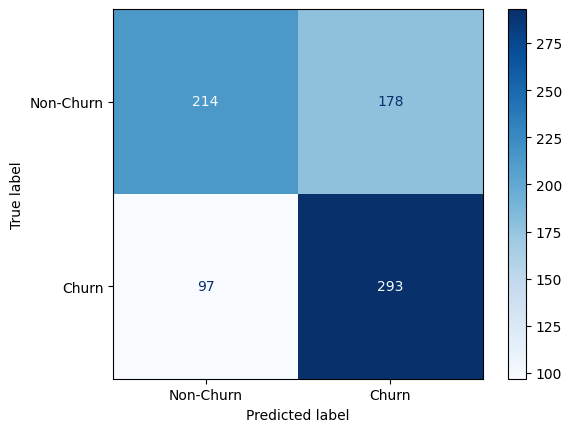

In [66]:
predictions_pd = predictions.select("prediction", "Churn_index").toPandas()

cm = confusion_matrix(predictions_pd['Churn_index'], predictions_pd['prediction'])
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Churn', 'Churn'])
disp.plot(cmap=plt.cm.Blues)
plt.show()